## Adversial debiasing 

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from aif360.algorithms.inprocessing import AdversarialDebiasing
from aif360.datasets import StandardDataset
import tensorflow.compat.v1 as tf
from sklearn.metrics import accuracy_score, classification_report

pip install 'aif360[Reductions]'
pip install 'aif360[Reductions]'
pip install 'aif360[inFairness]'
pip install 'aif360[Reductions]'


In [2]:
tf.keras.backend.clear_session()

In [3]:
# Disable eager execution for compatibility with aif360
tf.disable_eager_execution()

In [4]:
# Load the data
data = pd.read_csv('Final\wholevalue.csv')

<>:2: SyntaxWarning: invalid escape sequence '\w'
<>:2: SyntaxWarning: invalid escape sequence '\w'
C:\Users\ssrut\AppData\Local\Temp\ipykernel_2816\2425638206.py:2: SyntaxWarning: invalid escape sequence '\w'
  data = pd.read_csv('Final\wholevalue.csv')


In [5]:
# Encode gender (binary: 0 = female, 1 = male)
label_encoder = LabelEncoder()
data['Gender'] = label_encoder.fit_transform(data['Gender'])

In [6]:
# Separate features and target (assuming 'Gender' as the sensitive attribute and 'Average Course Outcome Level' as the target)
sensitive_attr = 'Gender'
target = 'Average Course Outcome Level'
X = data.drop(columns=[sensitive_attr, target])
y = data[target]
gender = data[sensitive_attr]

In [7]:
# Create a standardized dataset for AIF360
dataset = StandardDataset(
    data,
    label_name=target,
    favorable_classes=[5],  # Adjust as needed for favorable outcome
    protected_attribute_names=[sensitive_attr],
    privileged_classes=[[1]]  # Assuming male is privileged
)

In [8]:
# Split the data into training and testing sets
dataset_train, dataset_test = dataset.split([0.7], shuffle=True)

In [ ]:
# Function to calculate demographic parity
def demographic_parity(labels, protected_attributes):
    # Calculate the rate of positive outcomes for each group (male and female)
    privileged_group = protected_attributes == 1  # Assuming '1' represents male
    unprivileged_group = protected_attributes == 0  # Assuming '0' represents female

    privileged_rate = np.mean(labels[privileged_group])  # Positive rate for males
    unprivileged_rate = np.mean(labels[unprivileged_group])  # Positive rate for females

    return privileged_rate, unprivileged_rate

# Calculate and display demographic parity before training using dataset_test labels and protected attributes
privileged_rate_before, unprivileged_rate_before = demographic_parity(dataset_test.labels, dataset_test.protected_attributes[:, 0])

# Print the demographic parity before training
print(f"Demographic Parity (Before): {privileged_rate_before:.2f} (male), {unprivileged_rate_before:.2f} (female)")

# Calculate and print Disparate Impact before training
disparate_impact_before = privileged_rate_before / unprivileged_rate_before
print(f"Disparate Impact (Before): {disparate_impact_before:.2f} (male to female ratio)")


Demographic Parity (Before): 0.58 (male), 0.48 (female)
Disparate Impact (Before): 1.21 (male to female ratio)


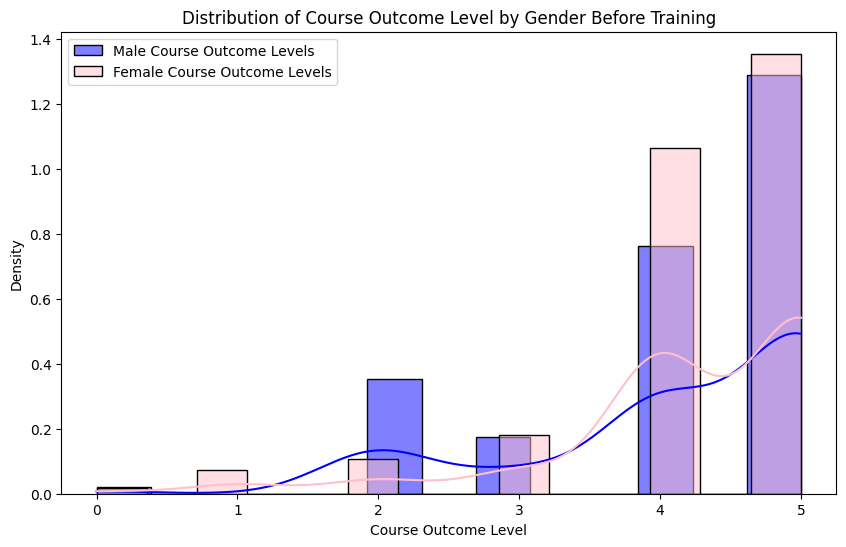

In [10]:
# Plot demographic parity before training
plt.figure(figsize=(10, 6))
sns.histplot(data[target][data[sensitive_attr] == 1], color='blue', label='Male Course Outcome Levels', kde=True, stat="density")
sns.histplot(data[target][data[sensitive_attr] == 0], color='pink', label='Female Course Outcome Levels', kde=True, stat="density")
plt.title("Distribution of Course Outcome Level by Gender Before Training")
plt.xlabel("Course Outcome Level")
plt.ylabel("Density")
plt.legend()
plt.show()

In [ ]:
# Set up the Adversarial Debiasing model
sess = tf.Session()
adversarial_model = AdversarialDebiasing(
    privileged_groups=[{sensitive_attr: 1}],
    unprivileged_groups=[{sensitive_attr: 0}],
    scope_name='adversarial_debiasing',
    sess=sess,
    num_epochs=50  
)

In [12]:
# Train the model
adversarial_model.fit(dataset_train)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


epoch 0; iter: 0; batch classifier loss: 1.698071; batch adversarial loss: 0.737722
epoch 1; iter: 0; batch classifier loss: 1.578377; batch adversarial loss: 0.687610
epoch 2; iter: 0; batch classifier loss: 1.222755; batch adversarial loss: 0.705732
epoch 3; iter: 0; batch classifier loss: 1.423687; batch adversarial loss: 0.708825
epoch 4; iter: 0; batch classifier loss: 1.327813; batch adversarial loss: 0.750742
epoch 5; iter: 0; batch classifier loss: 1.161260; batch adversarial loss: 0.705982
epoch 6; iter: 0; batch classifier loss: 1.084918; batch adversarial loss: 0.659540
epoch 7; iter: 0; batch classifier loss: 1.243861; batch adversarial loss: 0.805461
epoch 8; iter: 0; batch classifier loss: 0.976713; batch adversarial loss: 0.774725
epoch 9; iter: 0; batch classifier loss: 1.018439; batch adversarial loss: 0.757620
epoch 10; iter: 0; batch classifier loss: 1.330625; batch adversarial loss: 0.795163
epoch 11; iter: 0; batch classifier loss: 1.612636; batch adversarial loss:

In [13]:
# Make predictions
dataset_pred_train = adversarial_model.predict(dataset_train)
dataset_pred_test = adversarial_model.predict(dataset_test)


In [14]:
# Evaluate the model
y_pred_test = dataset_pred_test.labels
print("Testing Accuracy:", accuracy_score(dataset_test.labels, y_pred_test))
print("Classification Report:\n", classification_report(dataset_test.labels, y_pred_test))

Testing Accuracy: 0.5517241379310345
Classification Report:
               precision    recall  f1-score   support

         0.0       0.67      0.10      0.17        41
         1.0       0.54      0.96      0.69        46

    accuracy                           0.55        87
   macro avg       0.60      0.53      0.43        87
weighted avg       0.60      0.55      0.45        87



In [15]:
# Calculate fairness metrics after applying bias mitigation
privileged_mask = dataset_test.protected_attributes[:, 0] == 1
unprivileged_mask = dataset_test.protected_attributes[:, 0] == 0
privileged_rate_after, unprivileged_rate_after = demographic_parity(y_pred_test, dataset_test.protected_attributes[:, 0])
print(f"Demographic Parity (After): {privileged_rate_after:.2f} (male), {unprivileged_rate_after:.2f} (female)")
di_privileged_to_unprivileged_after = privileged_rate_after / unprivileged_rate_after
print(f"Disparate Impact (After): {di_privileged_to_unprivileged_after:.2f} (male to female ratio)")


Demographic Parity (After): 0.93 (male), 0.93 (female)
Disparate Impact (After): 1.01 (male to female ratio)


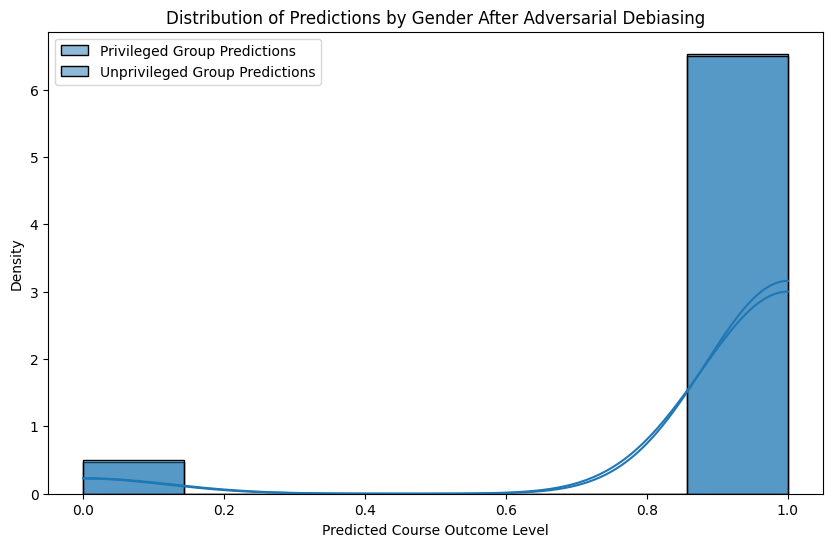

In [17]:
# Plot distributions of predictions for each gender to visualize demographic parity after training
plt.figure(figsize=(10, 6))
sns.histplot(y_pred_test[privileged_mask], color='blue', label='Privileged Group Predictions', kde=True, stat="density")
sns.histplot(y_pred_test[unprivileged_mask], color='pink', label='Unprivileged Group Predictions', kde=True, stat="density")
plt.title("Distribution of Predictions by Gender After Adversarial Debiasing")
plt.xlabel("Predicted Course Outcome Level")
plt.ylabel("Density")
plt.legend()
plt.show()
